In [1]:
import datetime as dt
from typing import List
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [2]:
df = pd.read_csv("../input_data/btf_periods900.csv")
df["CloseTime"] = df["CloseTime"].apply(dt.datetime.fromtimestamp)
rename_dict = {
        "CloseTime": "timestamp",
        "OpenPrice": "open",
        "HighPrice": "high",
        "LowPrice": "low",
        "ClosePrice": "close",
        "Volume": "volume",
    }
df = df[list(rename_dict.keys())].rename(columns=rename_dict).set_index("timestamp")
fee_rate = 0.15 / 100   # 売買手数料
slippage = 0.1 / 100    # 成行の想定スリッページ

- スリッページは実際に運用してみて測定するしかないっぽい
https://ryota-trade.com/?p=6180

In [3]:
# テクニカル指標を計算する
# 
class MyTAStratSet:
    """Utils for pandas_ta.Strategy.
    See https://github.com/twopirllc/pandas-ta/blob/main/examples/PandasTA_Strategy_Examples.ipynb

    """

    def __init__(self):
        # エンバーゴ用
        self.max_length = 0
        # 不要な列を削除するためのリスト
        self.unnecessary_cols = []

    def roc(self, length_list: List[int]):
        strats = []
        for length in length_list:
            s = [
                {"kind": "roc", "length": length, "close": "close", "prefix": "close"},
                # {"kind": "roc", "length": length, "close": "open", "prefix": "open"},
                # {"kind": "roc", "length": length, "close": "high", "prefix": "high"},
                # {"kind": "roc", "length": length, "close": "low", "prefix": "low"},
            ]
            self.max_length = max(self.max_length, length)
            strats += s
        return strats

    def sma_roc(self, length_list: List[int]):
        strats = []
        for length in length_list:
            s = [
                {"kind": "sma", "length": length, "close": "close", "prefix": "close"},
                {
                    "kind": "roc",
                    "length": length,
                    "close": f"close_SMA_{length}",
                    "prefix": f"close_SMA_{length}",
                },
            ]
            self.unnecessary_cols.append(f"close_SMA_{length}")
            self.max_length = max(self.max_length, length)
            strats += s
        return strats

    def return_sma(self, length_list: List[int]):
        strats = []
        for length in length_list:
            s = [
                {"kind": "roc", "length": 1, "close": "close", "prefix": "close"},
                {
                    "kind": "sma",
                    "length": length,
                    "close": f"close_ROC_{1}",
                    "prefix": f"close_ROC_{1}",
                },
            ]
            self.unnecessary_cols.append(f"close_ROC_{1}")
            self.max_length = max(self.max_length, length)
            strats += s
        return strats

    def basicstats(self, length_list: List[int]):
        strats = []
        for length in length_list:
            s = [
                {"kind": "zscore", "length": length},
                {"kind": "skew", "length": length},
                {"kind": "entropy", "length": length},
            ]
            self.max_length = max(self.max_length, length)
            strats += s
        return strats

    def vola(self, length_list: List[int]):
        strats = []
        for length in length_list:
            s = [
                {"kind": "stdev", "length": length},
                {"kind": "atr", "length": length},
                {"kind": "rvi", "length": length},
                {"kind": "massi", "fast": int(length / 2), "slow": length},
            ]
            self.max_length = max(self.max_length, length)
            strats += s
        return strats

    def momentum(self, length_list: List[int]):
        strats = []
        for length in length_list:
            s = [
                {"kind": "rsi", "length": length},
                {"kind": "macd", "fast": int(length / 2), "slow": length},
                {"kind": "psl", "length": length, "close": "close", "open_": "open"},
            ]
            self.max_length = max(self.max_length, length)
            strats += s
        return strats

In [27]:
df = pd.read_csv("../input_data/btf_periods900.csv")
df["CloseTime"] = df["CloseTime"].apply(dt.datetime.fromtimestamp)
rename_dict = {
        "CloseTime": "timestamp",
        "OpenPrice": "open",
        "HighPrice": "high",
        "LowPrice": "low",
        "ClosePrice": "close",
        "Volume": "volume",
    }
df = df[list(rename_dict.keys())].rename(columns=rename_dict).set_index("timestamp")
fee_rate = 0.15 / 100   # 売買手数料
slippage = 0.1 / 100    # 成行の想定スリッページ

# テクニカル指標を計算する
myset = MyTAStratSet()
strategy = ta.Strategy(
    name="mystrat",
    ta=myset.roc(list(range(5, 50, 5)))
    # + myset.basicstats([5, 10])
    + myset.vola(list(range(5, 50, 5)))
)
df.ta.strategy(strategy)

# その他の指標を計算する
df["weekday"] = df.index.weekday
df["hour"] = df.index.hour
df["minute"] = df.index.minute

In [29]:
for i in range(5, 50, 5):
    df[f"close_ROC_{i}_norm"] = df[f"close_ROC_{i}"] / i
    df[f"sharpratio_{i}"] = df[f"close_ROC_{i}"] / df[f"STDEV_{i}"]

In [5]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'close_ROC_5', 'close_ROC_10',
       'close_ROC_15', 'close_ROC_20', 'close_ROC_25', 'close_ROC_30',
       'close_ROC_35', 'close_ROC_40', 'close_ROC_45', 'weekday', 'hour',
       'minute'],
      dtype='object')


In [31]:
df

,open,high,low,close,volume,close_ROC_5,close_ROC_10,close_ROC_15,close_ROC_20,close_ROC_25,...,close_ROC_25_norm,sharpratio_25,close_ROC_30_norm,sharpratio_30,close_ROC_35_norm,sharpratio_35,close_ROC_40_norm,sharpratio_40,close_ROC_45_norm,sharpratio_45
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-27 06:45:00,3002059,3005999,2999462,3002677,11.104998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-27 07:00:00,3002677,3005400,3002677,3005233,1.200600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-27 07:15:00,3005233,3014000,3003500,3005769,14.542887,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-27 07:30:00,3006506,3007610,3000472,3002485,5.748022,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-27 07:45:00,3000720,3002001,2998195,2998195,1.606233,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-07 08:00:00,3694265,3697704,3692642,3697621,2.487820,0.096886,-0.235353,0.170969,-0.002082,-0.252819,...,-0.010113,-0.000048,-0.004491,-0.000021,0.008805,0.000045,0.011614,0.000057,0.007795,0.000040
2023-04-07 08:15:00,3697103,3704996,3697103,3703234,4.091043,0.282278,-0.040435,0.125859,0.123450,0.114626,...,0.004585,0.000021,-0.008093,-0.000042,0.011392,0.000059,0.009722,0.000048,0.010799,0.000055
2023-04-07 08:30:00,3703234,3703236,3698142,3700003,3.496708,0.368515,0.213020,0.028765,-0.163758,0.073513,...,0.002941,0.000014,-0.003698,-0.000020,0.013895,0.000079,0.008817,0.000044,0.012079,0.000064


# アノマリー

- 曜日アノマリー
    - 0が月曜, 1が火曜...

- 金曜だけめっちゃ負けとる
    - 1週間の終わりに手仕舞いする人が多い？

Text(0, 0.5, 'n期リターンの平均')

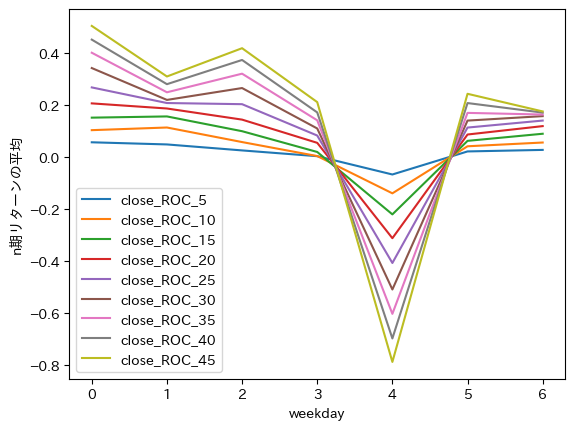

In [19]:
# n期リターン 各曜日全期間の平均
df.groupby("weekday").mean()[[f"close_ROC_{i}" for i in range(5, 50, 5)]].plot()

plt.ylabel("n期リターンの平均")

Text(0, 0.5, 'n期リターンの平均')

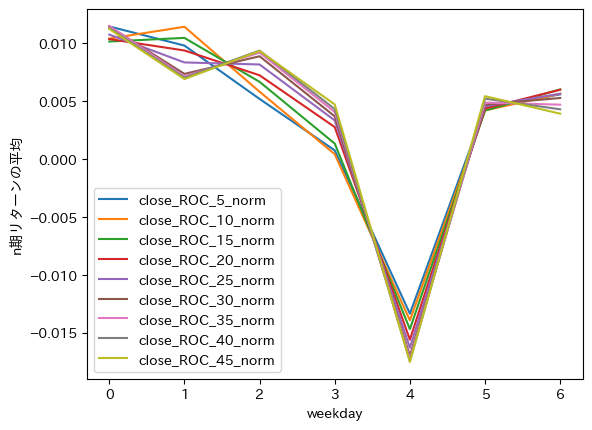

In [26]:
# n期リターン 各曜日全期間の平均
# normalization
df.groupby("weekday").mean()[[f"close_ROC_{i}_norm" for i in range(5, 50, 5)]].plot()

plt.ylabel("n期リターンの平均")

<Axes: xlabel='weekday'>

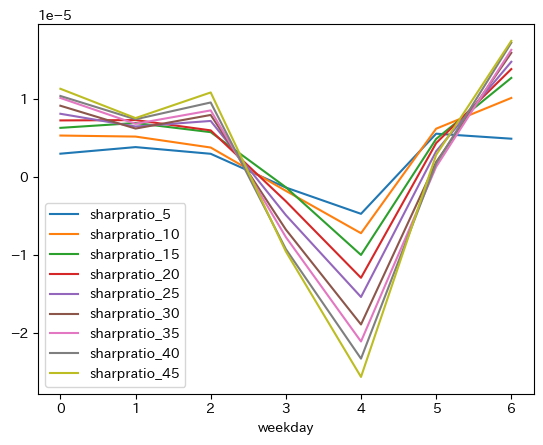

In [30]:
# sharpratio
df.groupby("weekday").mean()[[f"sharpratio_{i}" for i in range(5, 50, 5)]].plot()

(-1.0, 1.0)

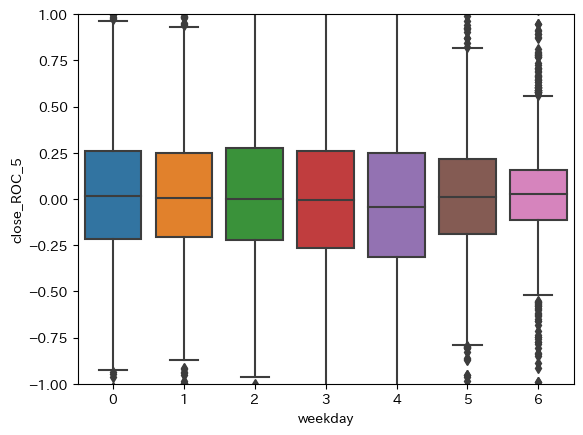

In [20]:
# 箱髭図
sns.boxplot(data=df, x="weekday", y=f"close_ROC_{5}")
plt.ylim((-1, 1))

<Axes: xlabel='weekday', ylabel='close_ROC_5'>

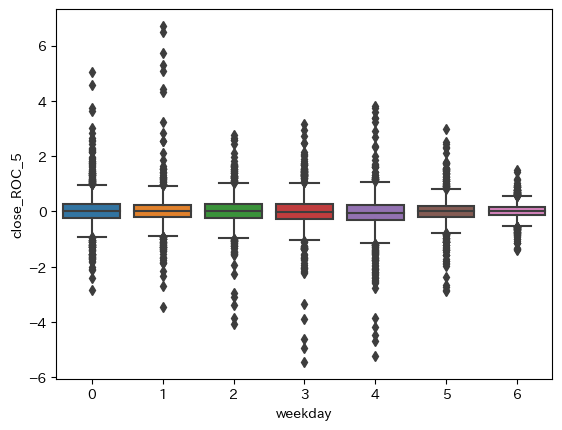

In [24]:
sns.boxplot(data=df, x="weekday", y=f"close_ROC_{5}")

(-1.0, 1.0)

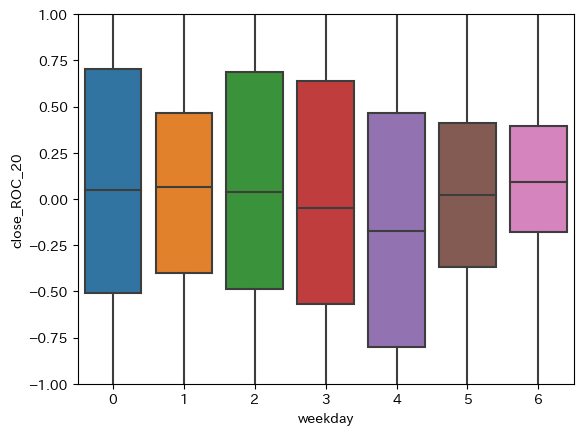

In [23]:
# 箱髭図
sns.boxplot(data=df, x="weekday", y=f"close_ROC_{20}")
plt.ylim((-1, 1))

- 手数料に勝つ必要があるので、ボラがでかいときに参加すべき
- ATRがでかいときに参加して, n期後に売る